### Kaggle / getting data

In [75]:
# !pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8 -q
# !mkdir /root/.kaggle

# with open("/root/.kaggle/kaggle.json", "w+") as f:
#     f.write('{"username":"shamikad","key":"8a5fa637778e375b261470b78b68bb89"}') # TODO: Put your kaggle username & key here

# !chmod 600 /root/.kaggle/kaggle.json
# # Download the dataset
# !kaggle datasets download -d "aryashah2k/breast-ultrasound-images-dataset" # this is the dataset that I used. It is free on kaggle
# #unzips the dataset file
# !unzip -q /content/breast-ultrasound-images-dataset.zip

### installs 

In [76]:
!pip install wandb --quiet
!pip install monai -q
!pip install opencv-python -q
!pip install tqdm -q
!pip install numpy -q
!pip install -U scikit-learn -q
!pip install matplotlib -q
!pip install torch -q

### Importing important libraries

In [77]:
import os #for file.io to get images
import cv2 #advanced image processing
from PIL import Image #Python's image processing
from tqdm import tqdm # to create loading bars while training so you can track progress
import numpy as np # manipulation of arrays
from sklearn.model_selection import train_test_split #needed to split train and val data
import matplotlib.pyplot as plt # needed for visualizing images
import wandb # to log, version, and track models that are training
import gc # to force garbage collection to clear RAM
import copy # create copies so as to not overwrite arrays

import torch #for all the ML stuff that monai doesn't have built in (monai is torch based so they integrate well)
import torch.nn as nn
from torchvision.transforms import Resize, Compose, ToTensor, ToPILImage
import torch.nn.functional as F

In [78]:
#all things that I used from monai
import monai
from monai.losses.dice import *
# from monai.losses.dice import DiceLoss
from monai.losses import GeneralizedDiceLoss
# from monai.losses import DiceFocalLoss
# from monai.losses import HausdorffDTLoss
from monai.data import DataLoader
from monai.data import Dataset
from monai.networks.nets import UNet
from monai.optimizers import Novograd
from monai.transforms import ThresholdIntensity
sharpener = ThresholdIntensity(1) # for output post processing

### Datasets and Data loaders

In [79]:
class Image_Mask_Loader(Dataset):

    def __init__(self , trainFlag = True, base_dir = r'/content/Dataset_BUSI_with_GT'):

        self.trainFlag = trainFlag #allows for the train and test data loader to use the same function

        self.base_dir = base_dir #directory that kaggle makes for images once unzipped

        #three folders of images (we will combine them all because we're doing segmentation, not classification)
        self.benign = os.path.join(self.base_dir , 'benign')
        self.malignant = os.path.join(self.base_dir , 'malignant')
        self.normal = os.path.join(self.base_dir , 'normal')

        self.transforms = Compose([ ToPILImage() , Resize((256 , 256)) ,  ToTensor()])

        #bulding the dataset, splits images into tumor images and masks (what we want the model output to be)
        self.total_images = []
        self.total_masks = []
        def splitMasks(baseDir, dir, imgsList, masksList):
          allPaths = sorted(os.listdir(dir)) #must sort because os.listdir returns in a random order by default
          i = 0
          while i < (len(allPaths)):
            if baseDir != "testing_data":
              img = os.path.join(baseDir, dir, allPaths[i]) #get the path of the image
            else:
              img = os.path.join(dir, allPaths[i])
            i += 1
            masks = []
            inMask = True
            while i < (len(allPaths)) and inMask:
              if baseDir != "testing_data":
                mask = os.path.join(baseDir, dir, allPaths[i]) #get the path of mask(s). There may be more than 1 per image
              else:
                mask = os.path.join(dir, allPaths[i])
              if "mask" in mask:
                masks.append(mask)
                i += 1
              else:
                inMask = False
            if len(masks) > 0:
              imgsList.append(img)
              masksList.append(masks)
            else:
              assert False # making sure that there are no empty mask lists appended
          return imgsList, masksList

        self.total_images, self.total_masks = splitMasks(self.base_dir, self.benign, self.total_images, self.total_masks) #go through all benign images
        self.total_images, self.total_masks = splitMasks(self.base_dir, self.malignant, self.total_images, self.total_masks) #go through all malignant images
        self.total_images, self.total_masks = splitMasks(self.base_dir, self.normal, self.total_images, self.total_masks) #go through all normal images (no tumor)

        assert(len(self.total_images)==len(self.total_masks)) #make sure that you have the same amount of images and masks

        self.train_images , self.test_images , self.train_masks , self.test_masks = train_test_split(self.total_images , self.total_masks , test_size = 0.33, random_state= 1)


    def __len__(self): #making it so that we can find the lengths of the datasets easily
        if (self.trainFlag):
            return len(self.train_images)
        else:
            return len(self.test_images)

    def __getitem__(self , idx):
        imgs = []
        masks = []
        if self.trainFlag: #choosing the right dataset for which ever one we are loading
            masks = self.train_masks
            imgs = self.train_images
            print(imgs)
        else:
            imgs = self.test_images
            masks = self.test_masks
        image = cv2.imread(imgs[idx]) #use open CV to read the image from the image file
        mask = cv2.imread(masks[idx][0] , 0) #use open CV to read the first of possibly many masks from the image file
        mask = mask.astype(np.float32)/255.0
        if len(masks[idx]) > 1:
          for i in range(1,len(masks[idx])): #join all the masks for each image into 1 mask of all tumors
            temp = cv2.imread(masks[idx][i] , 0)
            temp = temp.astype(np.float32)/255.0
            mask = cv2.add(mask, temp)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #convert colour images to grayscale because colour does not add additional information

        mask = mask.astype(np.float32)/255.0
        image = self.transforms(image)
        mask = self.transforms(mask)

        return image , mask


In [80]:
# base = r'/content/Dataset_BUSI_with_GT' #use if you're using the kaggle dataset (full data)
base = r"testing_data" #use if you're using the testing data (in the submission folder)

In [81]:
# create data loaders for the train and test sets
trainset = DataLoader(Image_Mask_Loader(True, base), batch_size = 16, shuffle = True) #want to shuffle the images so batches get mixed up train images
testset = DataLoader(Image_Mask_Loader(False, base) , batch_size = 16)

In [82]:
# check if the dataloader works
for (image, mask) in testset:
  imgNum = 1
  input_image = image[imgNum].numpy()
  groundtruth = mask[imgNum].numpy()
  print(input_image.shape)
  break

(1, 256, 256)


### Model creation

In [83]:
class ConvBlock(nn.Module):
    def __init__(self, inChan, out):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
          nn.Conv2d(inChan, out, kernel_size = 3, padding = 1),
          nn.ReLU(),
          nn.Conv2d(out, out, kernel_size = 3, padding = 1),
          nn.ReLU()
        )
    def forward(self, x):
        return self.block(x)

class myUNet(nn.Module):
    def __init__(self, inChan, out):
        super(myUNet, self).__init__()
        #creating encoder blocks
        self.block1 = nn.Sequential(
            ConvBlock(inChan, 64), #channel numbers increase by twice each time, which is the unet convention
            nn.MaxPool2d(kernel_size = 2, stride = 2) #kernel size and stride numbers taken from the monai documentations for their unet implimentation
        )
        self.block2 = nn.Sequential(
            ConvBlock(64, 128),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.block3 = nn.Sequential(
            ConvBlock(128, 256),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.block4 = nn.Sequential(
            ConvBlock(256, 512),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        #creating decoder blocks
        self.block5 = ConvBlock(512, 256) #decoder numbers are determined by the output sizes of the encoder blocks
        self.block6 = ConvBlock(512, 128)
        self.block7 = ConvBlock(256, 64)
        self.block8 = nn.Conv2d(128, out, kernel_size = 1)

    def forward(self, x):
        #encoder blocks -> need them separate to be used in the decoder blocks later
        e1 = self.block1(x)
        e2 = self.block2(e1)
        e3 = self.block3(e2)
        e4 = self.block4(e3)

        #decoder blocks
        d1 = self.block5(e4)
        d1 = F.interpolate(d1, scale_factor = 2, mode = 'bilinear', align_corners = True) #align corners preserves corner blocks of images

        d2 = self.block6(torch.cat([d1, e3], dim = 1))
        d2 = F.interpolate(d2, scale_factor = 2, mode = 'bilinear', align_corners = True) #bilinear upsampling uses linear interpolations of nearby pixels to calculate the values

        d3 = self.block7(torch.cat([d2, e2], dim = 1))
        d3 = F.interpolate(d3, scale_factor = 2, mode = 'bilinear', align_corners = True)

        d4 = self.block8(torch.cat([d3, e1], dim = 1))
        return F.interpolate(d4, scale_factor = 2, mode = 'bilinear', align_corners = True)


In [84]:
device = ["cuda" if torch.cuda.is_available() else "cpu"][0] #making sure you're using GPU if you have it

In [85]:
model = myUNet(1,  1).to(device)

# model = net = UNet(                       # <- monai's version of Unet. You can uncomment this to use the monai Unet instead of the unet implimented here
#     spatial_dims=2,
#     in_channels=1,
#     out_channels=1,
#     channels=(64, 64, 128, 256, 512),
#     strides=(2, 2, 2, 2),
#     num_res_units=2,
# ).to(device)

In [86]:
criterion = GeneralizedDiceLoss(sigmoid = True, reduction = "mean") #loss function to calculate model updates
optimizer = Novograd(model.parameters()) #optimizer to move the weights of the model to optimize the loss function
num_epochs = 30 #number of epochs to train the model on (if no early stopping)

In [87]:
# initializing stuff for early stopping
best_loss = float('inf') #want loss to be smaller, so we initialize it to the biggest number
plateau = 0
max_flat = 3

In [88]:
# force garbage collection -> this is needed so I don't run out of RAM while training
gc.collect()

3069

### WandB initialization

In [89]:
#wandb (weights and biases) is used for model logging. it saves different runs that I have so that I know which ones had which parameters
# if you would like to use wandb, put in your key and set useWandB to True. Otherwise, leave as is
useWandB = False
if useWandB:
  wandb.login(key="YOUR KEY HERE")

In [90]:
#wandb run initialization
if useWandB:
  run = wandb.init(
    name = "dice with distance loss", ## Wandb creates random run names if you skip this field
    reinit = True,
    project = "bmia-project",
  )

### Training

In [91]:
def train_model(best_loss = best_loss):
  for epoch in range(num_epochs):

      train_loss = 0
      model.train()
      for (image , mask) in (tqdm(trainset)): #training

          image = image.to(device)
          mask = mask.to(device)

          optimizer.zero_grad()

          outputs = model(image)

          loss = criterion(outputs , mask).mean()
          loss.backward() #get loss gradients
          optimizer.step() #step optimizer based on loss

          train_loss += loss.item()

      train_loss /= len(trainset)

      valid_loss = 0
      model.eval()
      for (image , mask) in (tqdm(testset)): #validation

          image = image.to(device)
          mask = mask.to(device)

          optimizer.zero_grad()

          outputs = sharpener(model(image)) #check the loss for the model output after post processing

          loss = criterion(outputs , mask).mean()

          valid_loss += loss.item()

      valid_loss /= len(testset)

      print(f'Epoch : {epoch} Train Loss : {train_loss} Validation Loss : {valid_loss}')
      if useWandB: #log loss information from the model to wandb if using it
        wandb.log({
                "train_loss":train_loss,
                "valid_loss":valid_loss})

      if valid_loss < best_loss:
          best_loss = train_loss
          plateau = 0 #reset the plateau every time we have a change
      else:
          plateau += 1

      if plateau >= max_flat: #early stopping if we start plateauing so that there is no overfitting
          break

In [92]:
#to train uncomment this line
# train_model()

In [93]:
#to save your trained model uncomment this line
# torch.save(model.state_dict(), "model.pth")

In [94]:
#Load a saved model (only use for testing)
model.load_state_dict(torch.load("Latest_model.pth", map_location=torch.device('cpu')))
model.to(device)

myUNet(
  (block1): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1,

### Visualizing Results

In [95]:
#get example images to visualize from the test set -> have 2 in case 1 is a "normal" image with no tumor
for (image, mask) in testset:
  model.eval()
  with torch.no_grad():
    output = model(image.to(device))
  imgNum = 1
  input_image = image[imgNum].numpy()
  output = output[imgNum].cpu().numpy() # convert to CPU becuse output is a tensor
  groundtruth = mask[imgNum].numpy()
  break

Text(0.5, 1.0, 'Input Image')

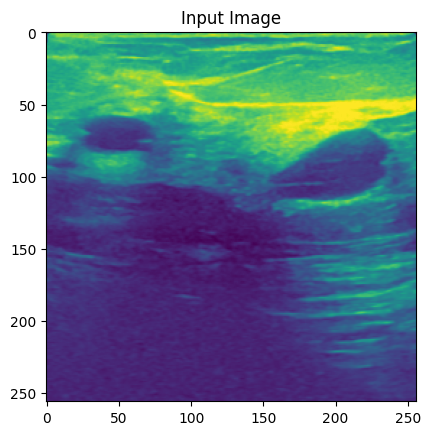

In [96]:
#visualize the input image
plt.imshow(input_image.reshape(256 , 256))
plt.title('Input Image')

Text(0.5, 1.0, 'Output Image')

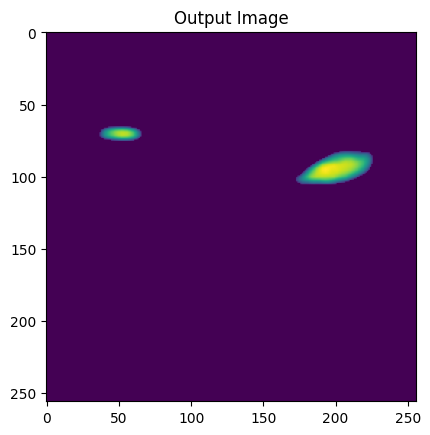

In [97]:
#visualize the output image
out = copy.deepcopy(output).reshape(256 , 256)
out = sharpener(out)
plt.imshow(out)
plt.title('Output Image')

Text(0.5, 1.0, 'Ground Truth Image')

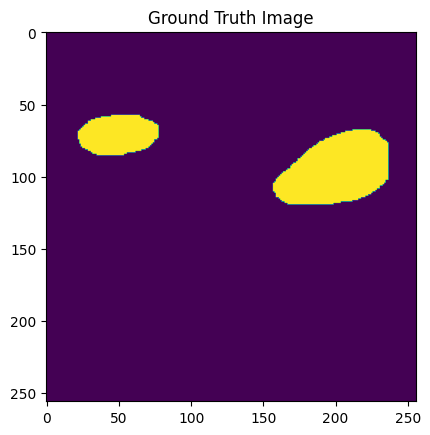

In [98]:
#visualize the groundtruth image
plt.imshow(groundtruth.reshape(256 , 256))
plt.title('Ground Truth Image')

In [99]:
#get example images to visualize from the test set -> have 2 in case 1 is a "normal" image with no tumor
for (image, mask) in testset:
  model.eval()
  with torch.no_grad():
    output = model(image.to(device))
  imgNum = 2
  input_image = image[imgNum].numpy()
  output = output[imgNum].cpu().numpy() # convert to CPU becuse output is a tensor
  groundtruth = mask[imgNum].numpy()
  break

Text(0.5, 1.0, 'Input Image')

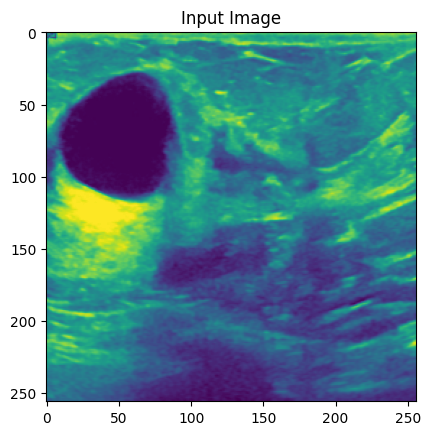

In [100]:
#visualize the input image
plt.imshow(input_image.reshape(256 , 256))
plt.title('Input Image')

Text(0.5, 1.0, 'Output Image')

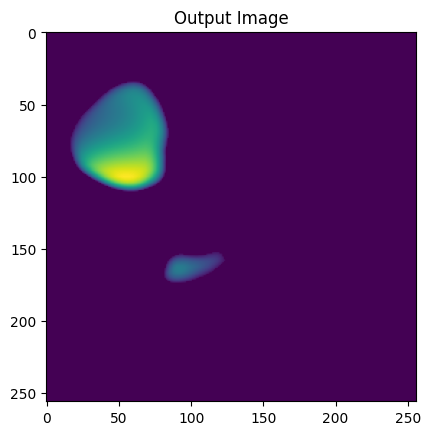

In [101]:
#visualize the output image
out = copy.deepcopy(output).reshape(256 , 256)
out = sharpener(out)
plt.imshow(out)
plt.title('Output Image')

Text(0.5, 1.0, 'Ground Truth Image')

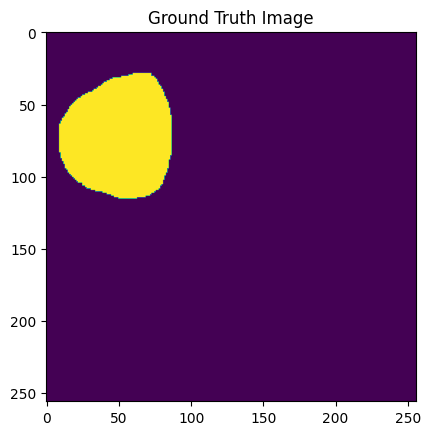

In [102]:
#visualize the groundtruth image
plt.imshow(groundtruth.reshape(256 , 256))
plt.title('Ground Truth Image')